In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.linear_model import LinearRegression
# from statsmodels.discrete.discrete_model import Logit
# from statsmodels.discrete.discrete_model import LogitResults
%matplotlib inline

/Users/yijunshen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
plt.style.use('seaborn-whitegrid')

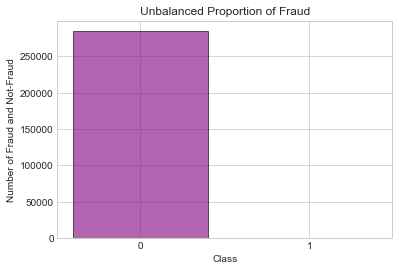

In [5]:
gp_class = data.groupby('Class')
class_count = gp_class['Class'].count()
plt.bar(range(len(class_count)),class_count,tick_label=list(class_count.index), alpha=0.6, color = 'purple', edgecolor = 'black')
plt.ylabel('Number of Fraud and Not-Fraud')
plt.xlabel('Class')
plt.title('Unbalanced Proportion of Fraud')
plt.show()

In [6]:
normal_data = data[data['Class'] == 0]
fraud_data = data[data['Class'] == 1]
normal_count = normal_data.shape[0]
fraud_count = fraud_data.shape[0]
total_count = data.shape[0]
normal_percent = normal_count / total_count
fraud_percent = fraud_count / total_count
print("Percentage of Normal Transaction:", normal_percent)
print("Percentage of Fraud Transaction:", fraud_percent)

Percentage of Normal Transaction: 0.9982725143693799
Percentage of Fraud Transaction: 0.001727485630620034


- The dataset is very unbalanced: 99.8% are normal transactions and only 0.2% are fraud transactions.
- Therefore, using ordinary logistic regression with threshold at 0.5 is not very suitable in this problem. We can tune the threshold so as to find a better one for such an imbalanced dataset.  
- The baseline model for this problem will be a zero-classifier, which classifies each transaction to be a normal one. Our task is to build a better classifier to beat this naive zero-classifier.

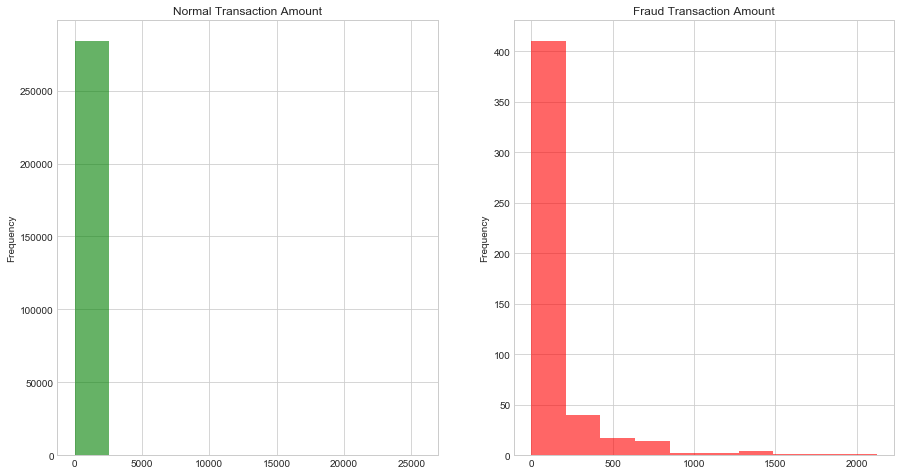

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
normal_amount = normal_data['Amount']
fraud_amount = fraud_data['Amount']

plt.subplot(1, 2, 1)
normal_amount.plot.hist(alpha=0.6, color = 'green')
plt.title("Normal Transaction Amount")

plt.subplot(1, 2, 2)
fraud_amount.plot.hist(alpha=0.6, color = 'red')
plt.title("Fraud Transaction Amount")

# plt.scatter("normal_amount")
plt.show()

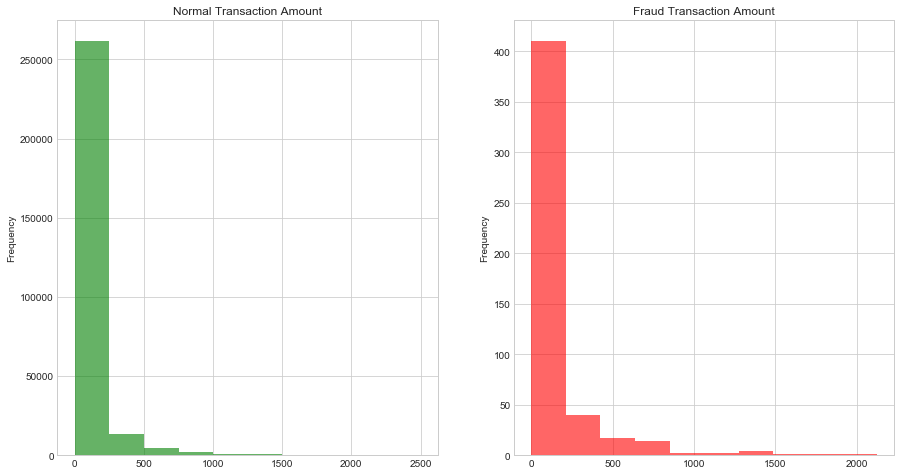

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
normal_amount_2500 = normal_data[normal_data['Amount'] <= 2500]['Amount']
fraud_amount_2500 = fraud_data[fraud_data['Amount'] <= 2500]['Amount']

plt.subplot(1, 2, 1)
normal_amount_2500.plot.hist(color='green', alpha=0.6)
plt.title("Normal Transaction Amount")

plt.subplot(1, 2, 2)
fraud_amount_2500.plot.hist(color='red', alpha=0.6)
plt.title("Fraud Transaction Amount")

# plt.scatter("normal_amount")
plt.show()

- Since the response variable "Transaction Amount" is very rightly skewed, we need to do a log-transformation on the response variable in the later linear regression problem.

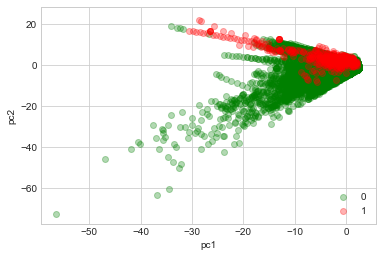

In [9]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
# colors = [c0, c1]
colors = ['green', 'red']

for label, color in zip(data['Class'].unique(), colors):
    mask = data['Class']==label
    plt.scatter(data[mask]['V1'], data[mask]['V2'], c=color, label=label, alpha=0.3)
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.legend(loc=4)
plt.show()

- The first two principal components can almost classified whether a transaction is a fraud or not. But there are still some overlaps which causes misclassifications if we only use two principle, which means we may need additional pricipal components as predictors.